<a href="https://colab.research.google.com/github/ehtisham-Fazal/ACP_SRC/blob/main/ACP_LSTM_comibned_740%26240.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ACP-DA: Improving the Prediction of Anticancer Peptides Using Data Augmentation**

In [4]:
#all pre-requiste libs
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, GRU, SimpleRNN
from keras.callbacks import ModelCheckpoint,TensorBoard
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import pickle
import scipy.io as sio
import numpy as np
from numpy import linalg as la
import argparse
!pip install wget
import wget
dataset_path='https://raw.githubusercontent.com/haichengyi/ACP-DL/master/acp240.txt'
wget.download(dataset_path, 'acp240.txt')
dataset_path='https://raw.githubusercontent.com/haichengyi/ACP-DL/master/acp740.txt'
wget.download(dataset_path, 'acp740.txt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=23a767aed52507841d68240c580a63d5e5756bc2d7b778d1831b38821cbfed02
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


'acp740.txt'

In [5]:
def TransDict_from_list(groups):
    transDict = dict()
    tar_list = ['0', '1', '2', '3', '4', '5', '6']
    result = {}
    index = 0
    for group in groups:
        g_members = sorted(group)  # Alphabetically sorted list
        for c in g_members:            
            result[c] = str(tar_list[index])  # K:V map, use group's first letter as represent.
        index = index + 1
    return result

def get_3_protein_trids():
    nucle_com = []
    chars = ['0', '1', '2', '3', '4', '5', '6']
    base = len(chars)
    end = len(chars) ** 3
    for i in range(0, end):
        n = i
        ch0 = chars[n % base]
        n = n / base
        ch1 = chars[int(n % base)]
        n = n / base
        ch2 = chars[int(n % base)]
        nucle_com.append(ch0 + ch1 + ch2)
    return nucle_com

def translate_sequence(seq, TranslationDict):
    '''
    Given (seq) - a string/sequence to translate,
    Translates into a reduced alphabet, using a translation dict provided
    by the TransDict_from_list() method.
    Returns the string/sequence in the new, reduced alphabet.
    Remember - in Python string are immutable..
    '''
    import string
    from_list = []
    to_list = []
    for k, v in TranslationDict.items():
        from_list.append(k)
        to_list.append(v)    
    TRANS_seq = seq.translate(str.maketrans(str(from_list), str(to_list)))    
    return TRANS_seq

def get_4_nucleotide_composition(tris, seq, pythoncount=True):
    seq_len = len(seq)
    tri_feature = [0] * len(tris)
    k = len(tris[0])
    note_feature = [[0 for cols in range(len(seq) - k + 1)] for rows in range(len(tris))]
    if pythoncount:
        for val in tris:
            num = seq.count(val)
            tri_feature.append(float(num) / seq_len)
    else:        
        for x in range(len(seq) + 1 - k):
            kmer = seq[x:x + k]
            if kmer in tris:
                ind = tris.index(kmer)                
                note_feature[ind][x] = note_feature[ind][x] + 1       
        u, s, v = la.svd(note_feature)
        for i in range(len(s)):
            tri_feature = tri_feature + u[i] * s[i] / seq_len
    return tri_feature

def prepare_feature_acp740():
    label = []
    interaction_pair = {}
    RNA_seq_dict = {}
    protein_seq_dict = {}
    protein_index = 0
    with open('acp740.txt', 'r') as fp:
        for line in fp:
            if line[0] == '>':
                values = line[1:].strip().split('|')
                label_temp = values[1]
                proteinName = values[0]
                if label_temp == '1':
                    label.append(1)
                else:
                    label.append(0)
            else:
                seq = line[:-1]
                protein_seq_dict[protein_index] = seq
                protein_index = protein_index + 1   
    groups = ['AGV', 'ILFP', 'YMTS', 'HNQW', 'RK', 'DE', 'C']
    group_dict = TransDict_from_list(groups)
    protein_tris = get_3_protein_trids()    
    bpf=[]
    kmer=[]
    for i in protein_seq_dict: 
        protein_seq = translate_sequence(protein_seq_dict[i], group_dict)
        bpf_feature = BPF(protein_seq_dict[i])       
        protein_tri_fea = get_4_nucleotide_composition(protein_tris, protein_seq, pythoncount =False)

        bpf.append(bpf_feature)
        kmer.append(protein_tri_fea)
    return np.array(bpf), np.array(kmer), label

def prepare_feature_acp240():
    label = []
    interaction_pair = {}
    RNA_seq_dict = {}
    protein_seq_dict = {}
    protein_index = 1
    with open('acp240.txt', 'r') as fp:
        for line in fp:
            if line[0] == '>':
                values = line[1:].strip().split('|')
                label_temp = values[1]
                protein = values[0]
                if label_temp=='1':
                    label.append(1)
                else:
                    label.append(0)
            else:
                seq = line[:-1]
                protein_seq_dict[protein_index] = seq
                protein_index = protein_index + 1    
    groups = ['AGV', 'ILFP', 'YMTS', 'HNQW', 'RK', 'DE', 'C']
    group_dict = TransDict_from_list(groups)
    protein_tris = get_3_protein_trids()    
    bpf = []
    kmer = []    
    for i in protein_seq_dict:  

        protein_seq = translate_sequence(protein_seq_dict[i], group_dict)
        bpf_feature = BPF(protein_seq_dict[i])        
        protein_tri_fea = get_4_nucleotide_composition(protein_tris, protein_seq, pythoncount =False)

        bpf.append(bpf_feature)
        kmer.append(protein_tri_fea)
        protein_index = protein_index + 1     

    return np.array(bpf), np.array(kmer), label

def BPF(seq_temp):
    seq = seq_temp
    chars = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    fea = []
    tem_vec =[]
    k = 7
    for i in range(k):
        if seq[i] =='A':
            tem_vec = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='C':
            tem_vec = [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='D':
            tem_vec = [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='E':
            tem_vec = [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='F':
            tem_vec = [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='G':
            tem_vec = [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='H':
            tem_vec = [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='I':
            tem_vec = [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='K':
            tem_vec = [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='L':
            tem_vec = [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='M':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='N':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]
        elif seq[i]=='P':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]
        elif seq[i]=='Q':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]
        elif seq[i]=='R':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]
        elif seq[i]=='S':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]
        elif seq[i]=='T':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]
        elif seq[i]=='V':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]
        elif seq[i]=='W':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]
        elif seq[i]=='Y':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
        fea = fea + tem_vec
    return fea

def prepare_feature():
    label = []
    interaction_pair = {}
    RNA_seq_dict = {}
    protein_seq_dict = {}
    protein_index = 1
    with open('acp740.txt', 'r') as fp:
        for line in fp:
            if line[0] == '>':
                values = line[1:].strip().split('|')
                label_temp = values[1]
                protein = values[0]
                if label_temp == '1':
                    label.append(1)
                else:
                    label.append(0)
            else:
                seq = line[:-1]
                protein_seq_dict[protein_index] = seq
                protein_index = protein_index + 1    
    groups = ['AGV', 'ILFP', 'YMTS', 'HNQW', 'RK', 'DE', 'C']
    group_dict = TransDict_from_list(groups)
    protein_tris = get_3_protein_trids()   
    train = []
    # get protein feature   
    for i in protein_seq_dict: 
        protein_seq = translate_sequence(protein_seq_dict[i], group_dict)       
        protein_tri_fea = get_4_nucleotide_composition(protein_tris, protein_seq, pythoncount =False)

        train.append(protein_tri_fea)
        protein_index = protein_index + 1       
    return np.array(train), label
    #performance measuring params 
def calculate_performace(test_num, pred_y, labels):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for index in range(test_num):
        if labels[index] == 1:
            if labels[index] == pred_y[index]:
                tp = tp + 1
            else:
                fn = fn + 1
        else:
            if labels[index] == pred_y[index]:
                tn = tn + 1
            else:
                fp = fp + 1
#performance measuring params formulas
    acc = float(tp + tn) / test_num
    precision = float(tp) / (tp + fp)
    sensitivity = float(tp) / (tp + fn)
    specificity = float(tn) / (tn + fp)
    B_acc=((sensitivity+specificity)/2)
    f1score = float(2 * tp) / (2 * tp + fp + fn)
    MCC = float(tp * tn - fp * fn) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    Y_I=sensitivity +specificity -1
    return acc, precision, sensitivity, specificity,f1score,B_acc,MCC,Y_I,

def transfer_label_from_prob(proba):
    label = [1 if val >= 0.5 else 0 for val in proba]
    return label
def plot_roc_curve(labels, probality, legend_text, auc_tag=True):    
    fpr, tpr, thresholds = roc_curve(labels, probality)  
    roc_auc = auc(fpr, tpr)
    if auc_tag:
        rects1 = plt.plot(fpr, tpr, label=legend_text + ' (AUC=%6.3f) ' % roc_auc)
    else:
        rects1 = plt.plot(fpr, tpr, label=legend_text)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm1 (LSTM)                (None, 128)               313344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 full_connect (Dense)        (None, 1)                 129       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 313,473
Trainable params: 313,473
Non-trainable params: 0
_________________________________________________________________
Compiling the Model...
Train...
Epoch 1/30
25/25 [==============================] - 2s 7ms/step - loss: 0.6767 - accuracy: 0.6531
Epoch 2/30
25/25 [==============================] - 

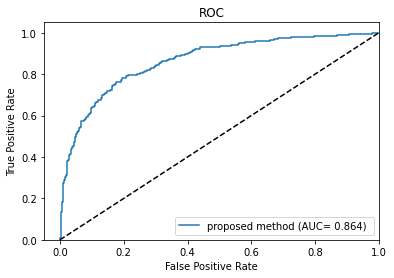

In [6]:
# define parameters
data_dim = 483
timesteps = 1
batch_size = 32   
epochs = 30
# get data
bpf_1, kmer_1, label_1 = prepare_feature_acp740()
bpf, kmer, label_2 = prepare_feature_acp240()
X = np.concatenate((bpf, kmer), axis=1)
y= np.concatenate((bpf_1, kmer_1), axis=1)
Datax=np.concatenate((X,y))
label=label_2+label_1
label=np.array(label)
X = np.reshape(Datax, (len(Datax), timesteps, data_dim))
# split data
num_cross_val = 5  # 5-fold
all_performance_lstm = []
all_labels = []
all_prob = {}
num_classifier = 3
all_prob[0] = []
all_average = []

for fold in range(num_cross_val):
    train = np.array([x for i, x in enumerate(X) if i % num_cross_val != fold])
    test = np.array([x for i, x in enumerate(X) if i % num_cross_val == fold])
    train_label = np.array([x for i, x in enumerate(label) if i % num_cross_val != fold])
    test_label = np.array([x for i, x in enumerate(label) if i % num_cross_val == fold])
    real_labels = []
    for val in test_label:
        if val == 1:
            real_labels.append(1)
        else:
            real_labels.append(0)

    train_label_new = []
    for val in train_label:
        if val == 1:
            train_label_new.append(1)
        else:
            train_label_new.append(0)
    all_labels = all_labels + real_labels
    #lstm model
    model = Sequential()    
    model.add(LSTM(128, return_sequences=False,input_shape=(timesteps, data_dim), name='lstm1'))  # returns a sequence of vectors of dimension 32
  
    model.add(Dropout(0.25, name='dropout'))
    model.add(Dense(1, name='full_connect'))
    model.add(Activation('sigmoid'))
    model.summary()

    print('Compiling the Model...')
    model.compile(loss='binary_crossentropy',  #
          optimizer='adam',
          metrics=['accuracy'])

    print("Train...")

    model.fit(train, train_label, batch_size=batch_size,epochs=epochs)    
    print(train.shape)
    print(test.shape)
    lstm_proba=model.predict(test)  

    all_prob[0] = all_prob[0] + [val for val in lstm_proba]
    y_pred_xgb = transfer_label_from_prob(lstm_proba)
    acc, precision, sensitivity, specificity,f1score,B_acc, MCC,Y_I = calculate_performace(len(real_labels), y_pred_xgb, real_labels)
    print(acc, precision, sensitivity, specificity, f1score, B_acc, MCC, Y_I)
    all_performance_lstm.append([acc, precision, sensitivity, specificity,f1score,B_acc, MCC,Y_I])
    print('---' * 50)

print('mean performance of ACP_DL')
print(np.mean(np.array(all_performance_lstm), axis=0))
print('---' * 50)
x=np.mean(np.array(all_performance_lstm), axis=0)
print("Balanced Accuracy={}, MCC={},  YOUDEN'S_iNDEX={}".format(x[-3],x[-2],x[-1]))
plot_roc_curve(all_labels, all_prob[0], 'proposed method')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
